In [469]:
# Importing initial packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("deep")
import matplotlib.pyplot as plt

# Setting the device to GPU for parallelization
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

mps


In [470]:
# Setting Hyperparameters
batch_size = 64
epochs = 4

In [471]:
# In my project folder I added a data folder with both files (found in repo README) but did not push (gitignore) due to size
movies = pd.read_csv('data/movies.csv')

ratings = pd.read_csv('data/ratings.csv')

In [472]:
# Creating encoders and decoders for our movie ids
movie_ids = list(movies.movieId)
moviesid_to_title = dict(zip(movies.movieId,movies.title))    # Decoder
movietitle_to_id = {j:i for i,j in moviesid_to_title.items()} # Encoder

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Data Preprocessing

In [473]:
# Assume NAs are not watched by user, so rating of 0
user_rating_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_rating_matrix_np = user_rating_matrix.values
train_data, test_data = train_test_split(user_rating_matrix_np, test_size=0.2, random_state=42)
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

In [474]:
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.data = data.nonzero(as_tuple=True) # Get the indices of non-zero elements
        self.ratings = data[self.data]          # Using non-zero indiced to extract those ratings

    def __len__ (self):
        return len(self.data[0])
    
    def __getitem__ (self, idx):
        user = self.data[0][idx]
        item = self.data[1][idx]
        rating = self.ratings[idx]
        
        return user, item, rating
    
train_dataset = RatingsDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

test_dataset = RatingsDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

In [475]:
criterion = nn.MSELoss()
num_users, num_items = user_rating_matrix_np.shape

# Models

### Model 1

Original Model Architecture
- Embed_Dim = 64
- 4 Linear Layers (128>128>64>16>1)
- 2 Dropouts (0.5, 0.4)
- 3 Batch Norms

In [476]:
class Model1(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 64):
        super(Model1, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        
        self.fc1 = nn.Linear(n_embd * 2, 128)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(128, 64)                         # Second fc layer
        self.fc3 = nn.Linear(64, 16)                          # Finaly fc layer, with an output of one value
        self.fc4 = nn.Linear(16, 1)                           # Finaly fc layer, with an output of one value
       
        self.sigmoid = nn.Sigmoid()                           # Sigmoid activation function to compress the output to a value between (0,1)
        
        self.dropout1 = nn.Dropout(0.5)                       # Dropout layer to prevent overfitting
        self.dropout2 = nn.Dropout(0.4)                       # Dropout layer to prevent overfitting
        
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(16)


    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)                                 # Final layer to get predicted rating
        x = self.sigmoid(x)                             # Applying the sigmoid function
        x = x*5                                         # Scale the output from [0,1] to [0,5]   
        return x

def initialise_model1(num_users= num_users, num_items=num_items, lr=0.03, wd=2.5e-5):
    global model
    model = Model1(num_users, num_items)
    model = model.to(device)
    global optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

## Model 2

- Embed_Dim = 32
- 4 Linear Layers (64>128>64>16>1)
- 2 Dropouts (0.5, 0.4)
- 3 Batch Norms

Less model complexity compared to Model 1 to combat overfitting

In [477]:
class Model2(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 32):
        super(Model2, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        
        self.fc1 = nn.Linear(n_embd * 2, 128)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(128, 64)                         # Second fc layer
        self.fc3 = nn.Linear(64, 16)                          # Finaly fc layer, with an output of one value
        self.fc4 = nn.Linear(16, 1)                           # Finaly fc layer, with an output of one value
       
        self.sigmoid = nn.Sigmoid()                           # Sigmoid activation function to compress the output to a value between (0,1)
        
        self.dropout1 = nn.Dropout(0.5)                       # Dropout layer to prevent overfitting
        self.dropout2 = nn.Dropout(0.4)                       # Dropout layer to prevent overfitting
        
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(16)


    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)                                 # Final layer to get predicted rating
        x = self.sigmoid(x)                             # Applying the sigmoid function
        x = x*5                                         # Scale the output from [0,1] to [0,5]   
        return x

def initialise_model2(num_users = num_users, num_items=num_items, lr=0.03, wd=2.5e-5):
    global model
    model = Model2(num_users, num_items)
    model = model.to(device)
    global optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

## Model 3
- Embed_Dim = 64
- 3 Linear Layers (128>128>32>1)
- 1 Dropout (0.5)
- 2 Batch Norms

Less model complexity compared to Model 2 to increase generalization

In [478]:
class Model3(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 64):
        super(Model3, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        
        self.fc1 = nn.Linear(n_embd * 2, 128)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(128, 32)                         # Second fc layer
        self.fc3 = nn.Linear(32, 1)                          # Finaly fc layer, with an output of one value
       
        self.sigmoid = nn.Sigmoid()                           # Sigmoid activation function to compress the output to a value between (0,1)
        
        self.dropout1 = nn.Dropout(0.5)                       # Dropout layer to prevent overfitting
        
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(32)


    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)                             # Applying the sigmoid function
        x = x*5                                         # Scale the output from [0,1] to [0,5]   
        return x

def initialise_model3(num_users = num_users, num_items=num_items, lr=0.03, wd=2.5e-5):
    global model
    model = Model3(num_users, num_items)
    model = model.to(device)
    global optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

## Model 4
- Embed_Dim = 64
- 4 Linear Layers (128>256>32>1)
- 2 Dropouts (0.5, 0.5)
- 2 Batch Norms

More model complexity (neurons) compared to Model 1, but more dropout.

In [479]:
class Model4(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 64):
        super(Model4, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        
        self.fc1 = nn.Linear(n_embd * 2, 256)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(256, 128)                         # Second fc layer
        self.fc3 = nn.Linear(128, 32)                          # Finaly fc layer, with an output of one value
        self.fc4 = nn.Linear(32, 1)                           # Finaly fc layer, with an output of one value
       
        self.sigmoid = nn.Sigmoid()                           # Sigmoid activation function to compress the output to a value between (0,1)
        
        self.dropout1 = nn.Dropout(0.5)                       # Dropout layer to prevent overfitting
        self.dropout2 = nn.Dropout(0.5)                       # Dropout layer to prevent overfitting
        
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(32)


    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)                                 # Final layer to get predicted rating
        x = self.sigmoid(x)                             # Applying the sigmoid function
        x = x*5                                         # Scale the output from [0,1] to [0,5]   
        return x

def initialise_model4(num_users= num_users, num_items=num_items, lr=0.03, wd=2.5e-5):
    global model
    model = Model4(num_users, num_items)
    model = model.to(device)
    global optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

## Training Loop Function

In [480]:
def training_loop(epochs=epochs):
    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        for user, item, rating in train_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            optimizer.zero_grad()
            output = model(user, item).squeeze()
            loss = criterion(output, rating)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Print loss after every epoch
        epoch_loss = total_loss/len(train_loader)          # Get the average loss for this epoch
        if epoch == epochs:
            print(f"    Train Loss: {epoch_loss}")    # Print the average loss for this epoch
    
    return epoch_loss                                      # Return the final loss

# training_loop()

## Val Loop Function

In [481]:
def validation_loop():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for user, item, rating in test_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            output = model(user, item).squeeze()
            loss = criterion(output, rating)
            total_loss += loss.item()
        
    test_loss = total_loss / len(test_loader)   

    print(f"    Test Loss: {test_loss}")
    return test_loss

# Model Testing

### Defining a fn to loop through Learning Rates, returning a dict of losses.

In [482]:
learning_rates = [0.0005,0.001, 0.003, 0.01, 0.015]
wd_list = [1e-5, 1.5e-5, 2.5e-5]

def parameter_fn(model = initialise_model1, name = "Model 1", lr_list= learning_rates, epochs = epochs):
    lr_dict = {'Name': name, 'learning_rate': [], 'weight_decay':[], 'training_loss': [], 'test_loss': [], 'test_diff':[]}
    for lr in lr_list:
        for wd in wd_list:
            print(f"Learning Rate: {lr}, Weight Decay: {wd}")
            model(lr=lr)
            training_loss = training_loop(epochs)
            test_loss = validation_loop()
            
            lr_dict['weight_decay'].append(wd)
            lr_dict['learning_rate'].append(lr)
            lr_dict['training_loss'].append(training_loss)
            lr_dict['test_loss'].append(test_loss)
            lr_dict['test_diff'].append((test_loss/training_loss)-1)

    return lr_dict

# lr_df=pd.DataFrame(learning_rate_fn())
# lr_df.sort_values(by='test_diff', ascending=True)

In [483]:
models = {initialise_model1:"Model 1", initialise_model2:"Model 2", initialise_model3:"Model 3", initialise_model4:"Model 4"}
loss_df = pd.DataFrame()
for model, name in models.items():
    print(f"Now processing: {name}")
    loss_dict = parameter_fn(model = model, name = name)
    loss_df = pd.concat([loss_df, pd.DataFrame(loss_dict)], ignore_index=True)
    
loss_df

Now processing: Model 1
Learning Rate: 0.0005, Weight Decay: 1e-05
    Train Loss: 0.9282948027228142
    Test Loss: 1.0048782176770459
Learning Rate: 0.0005, Weight Decay: 1.5e-05
    Train Loss: 0.9344362611849825
    Test Loss: 1.045527465280154
Learning Rate: 0.0005, Weight Decay: 2.5e-05
    Train Loss: 0.9369078664877615
    Test Loss: 0.9469935564328561
Learning Rate: 0.001, Weight Decay: 1e-05
    Train Loss: 0.8234299201961164
    Test Loss: 0.8994035676259367
Learning Rate: 0.001, Weight Decay: 1.5e-05
    Train Loss: 0.8124902720686856
    Test Loss: 0.8925459442389204
Learning Rate: 0.001, Weight Decay: 2.5e-05
    Train Loss: 0.8228060038096005
    Test Loss: 0.9230970582101004
Learning Rate: 0.003, Weight Decay: 1e-05
    Train Loss: 0.748649998118619
    Test Loss: 0.8765907341369168
Learning Rate: 0.003, Weight Decay: 1.5e-05
    Train Loss: 0.750152907822724
    Test Loss: 0.8822431649505128
Learning Rate: 0.003, Weight Decay: 2.5e-05
    Train Loss: 0.7502917549410066

,Name,learning_rate,weight_decay,training_loss,test_loss,test_diff
0,Model 1,0.0005,0.000010,0.928295,1.004878,0.082499
1,Model 1,0.0005,0.000015,0.934436,1.045527,0.118886
2,Model 1,0.0005,0.000025,0.936908,0.946994,0.010765
3,Model 1,0.0010,0.000010,0.823430,0.899404,0.092265
4,Model 1,0.0010,0.000015,0.812490,0.892546,0.098531
5,Model 1,0.0010,0.000025,0.822806,0.923097,0.121889
6,Model 1,0.0030,0.000010,0.748650,0.876591,0.170895
7,Model 1,0.0030,0.000015,0.750153,0.882243,0.176084
8,Model 1,0.0030,0.000025,0.750292,0.880017,0.172899
9,Model 1,0.0100,0.000010,0.763723,0.915865,0.199212


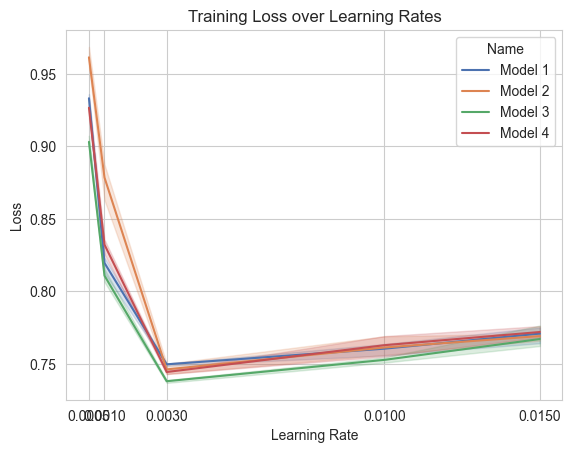

In [484]:
sns.lineplot(data = loss_df,
             x = "learning_rate",
             y = "training_loss",
             hue = "Name")
plt.title("Training Loss over Learning Rates")
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xticks(learning_rates)
plt.show()

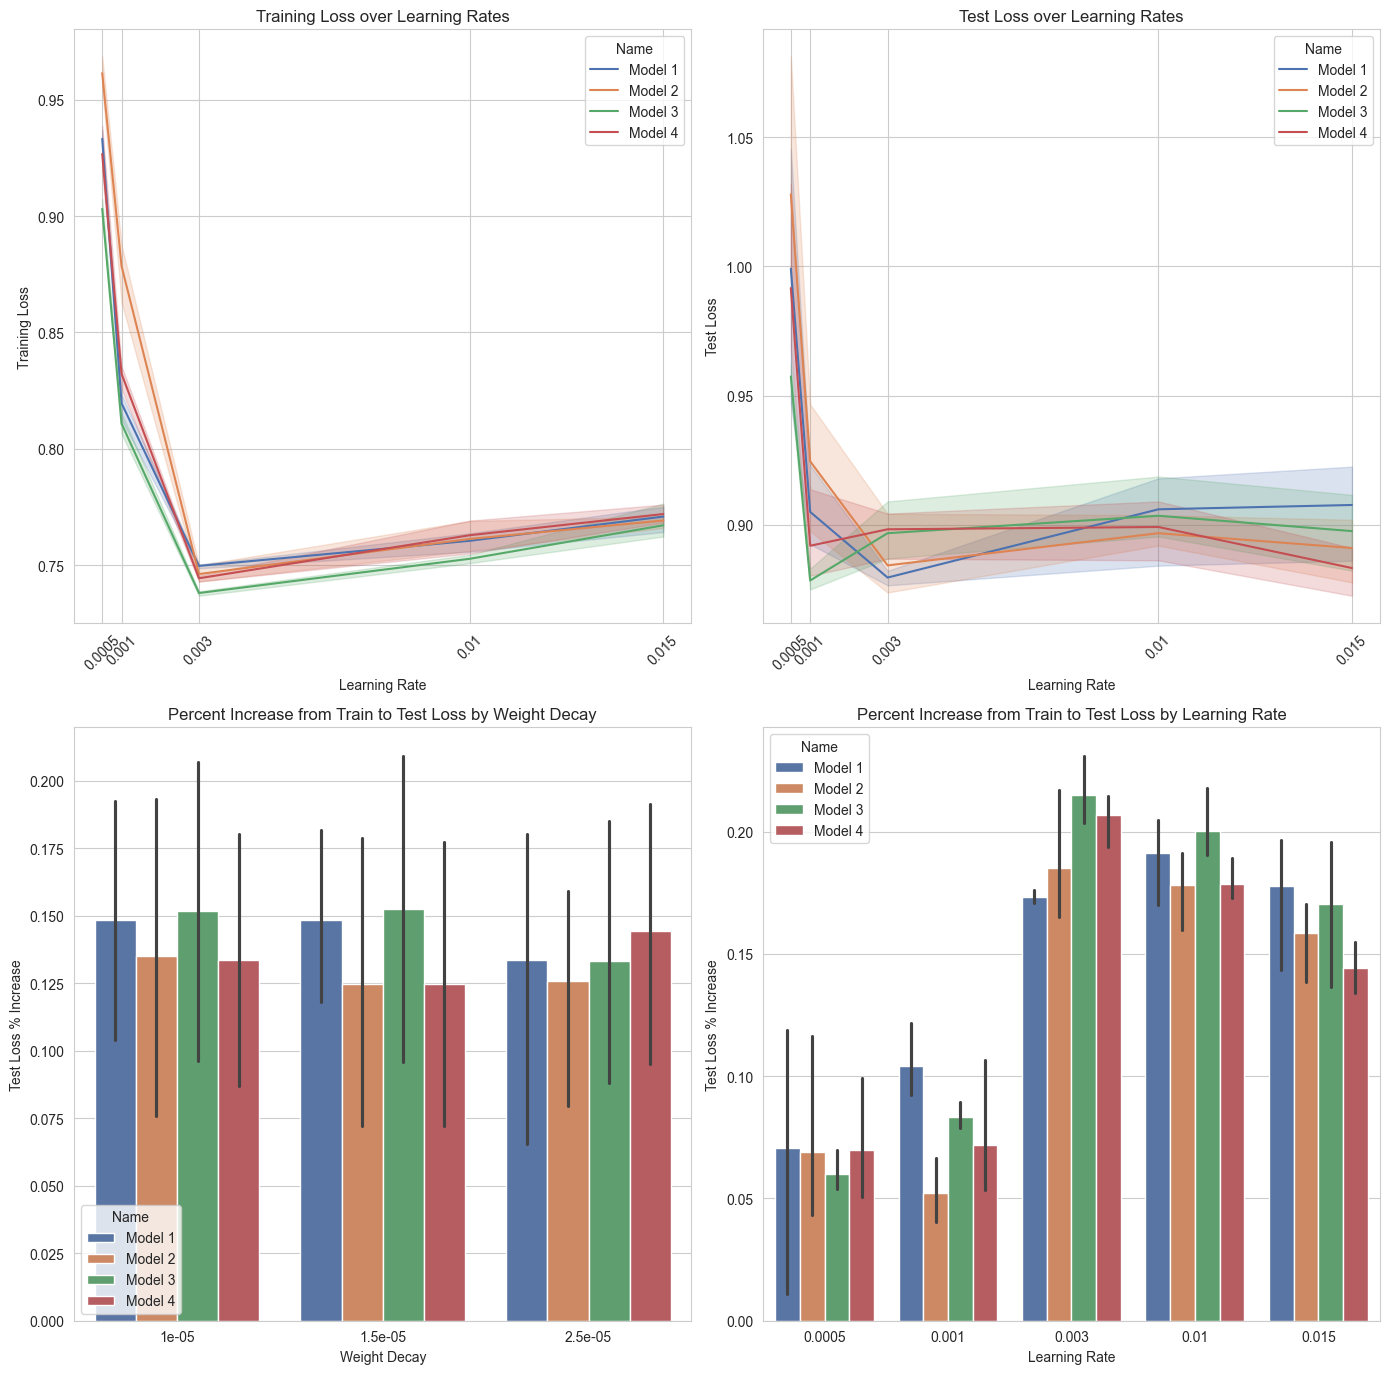

In [485]:
fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharey=False)

sns.lineplot(data = loss_df,
            ax=axes[0,0],
             x = "learning_rate",
             y = "training_loss",
             hue = "Name")
axes[0,0].set_title("Training Loss over Learning Rates")
axes[0,0].set_xlabel('Learning Rate')
axes[0,0].set_ylabel('Training Loss')
axes[0,0].set_xticks(learning_rates)
axes[0,0].set_xticklabels(learning_rates, rotation=45)

sns.lineplot(data = loss_df,
            ax=axes[0,1],
             x = "learning_rate",
             y = "test_loss",
             hue = "Name")
axes[0,1].set_title("Test Loss over Learning Rates")
axes[0,1].set_xlabel('Learning Rate')
axes[0,1].set_ylabel('Test Loss')
axes[0,1].set_xticks(learning_rates)
axes[0,1].set_xticklabels(learning_rates, rotation=45)

sns.barplot(data = loss_df,
            ax=axes[1,0],
             x = "weight_decay",
             y = "test_diff",
             hue = "Name")
axes[1,0].set_title('Percent Increase from Train to Test Loss by Weight Decay')
axes[1,0].set_xlabel('Weight Decay')
axes[1,0].set_ylabel('Test Loss % Increase')
# axes[1].set_xticks(wd_list)
# axes[1].set_xticklabels(wd_list, rotation=45)

sns.barplot(data = loss_df,
            ax=axes[1,1],
             x = "learning_rate",
             y = "test_diff",
             hue = "Name")
axes[1,1].set_title('Percent Increase from Train to Test Loss by Learning Rate')
axes[1,1].set_xlabel('Learning Rate')
axes[1,1].set_ylabel('Test Loss % Increase')
# axes[1].set_xticks(wd_list)
# axes[1].set_xticklabels(wd_list, rotation=45)


plt.suptitle('')
plt.tight_layout()
plt.show()

After looking at the figurs above, the following stands out:
- Weight Decay values seem to not have a great difference between models, so we will contineu with 1e-5
- Learning Rate of 0.003 had the lowest training loss, but the test loss began to increase. Figure 1,1 shows a dramatic jump at 0.003, so we will continue with Learning Rate = 0.001
- For Model choice, Model 2 seemed to show the least amount of overfit and best generalization, so we will continue with that, tweaking minor aspects in the main script as needed.

# Checking Model

In [486]:
initialise_model2(lr = 0.001,wd=1e-5)
training_loop()
validation_loop()

    Train Loss: 0.9039235957800509
    Test Loss: 0.9407935599015712


0.9407935599015712

In [487]:
def ratings_review(user_id, movie_ids):
    model.eval()                                 # Set model to evaluation mode
    user = torch.tensor([user_id] * len(movie_ids)).to(device)  # Ensure tensor is on the same device as the model
    movies = torch.tensor(movie_ids).to(device)  # Ensure tensor is on the same device as the model
    with torch.no_grad():
        predicted_ratings = model(user, movies).squeeze().tolist()

    return predicted_ratings

ratings_list = []
for id in ratings.userId.unique():
        recommended_movies = ratings_review(id, movie_ids)
        ratings_list.append(recommended_movies[0])

[]

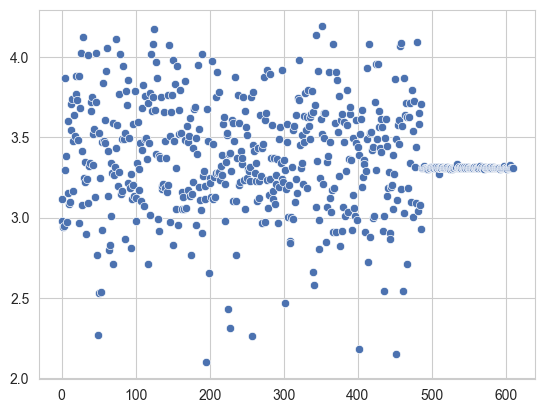

In [488]:
sns.scatterplot(ratings_list)
plt.plot()

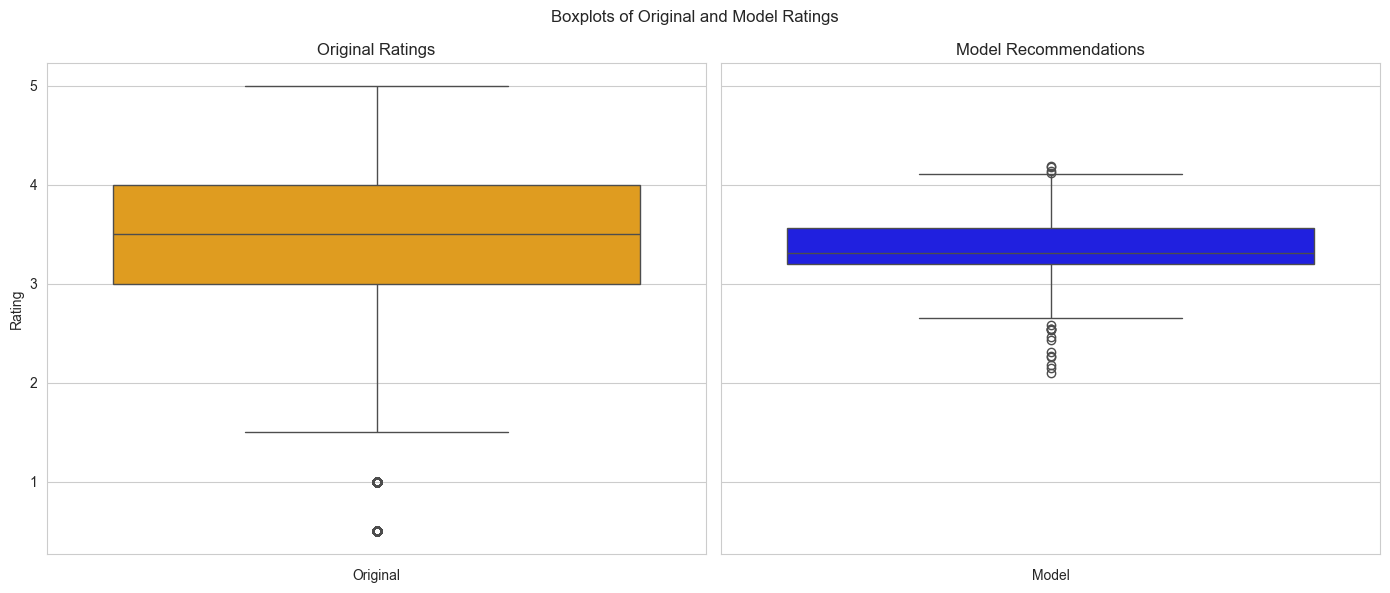

In [489]:
ratings_series = pd.Series(ratings_list)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original Data
sns.boxplot(y=ratings['rating'], ax=axes[0], color='orange')
axes[0].set_title('Original Ratings')
axes[0].set_xlabel('Original')
axes[0].set_ylabel('Rating')

# Model Data
sns.boxplot(y=ratings_series, ax=axes[1], color='blue')
axes[1].set_title('Model Recommendations')
axes[1].set_xlabel('Model')

# Adjust layout
plt.suptitle('Boxplots of Original and Model Ratings')
plt.tight_layout()
plt.show()

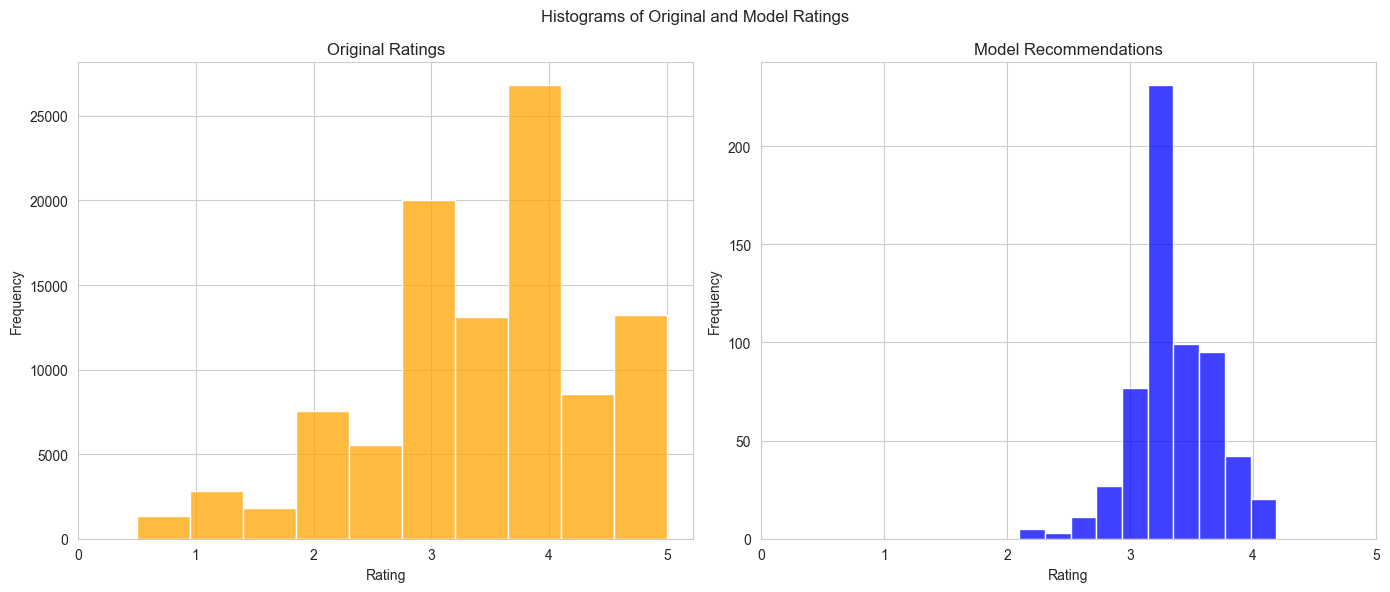

In [490]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
xticks = [0, 1, 2, 3, 4, 5]

bins = 10
# Original Data
sns.histplot(x=ratings['rating'], bins = bins, ax=axes[0], color='orange')
axes[0].set_title('Original Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(xticks)

# Model Data
sns.histplot(x=ratings_series, bins = bins, ax=axes[1], color='blue')
axes[1].set_title('Model Recommendations')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(xticks)


# Adjust layout
plt.suptitle('Histograms of Original and Model Ratings')
plt.tight_layout()
plt.show()

In [491]:
ratings_series = pd.Series(ratings_list)
ratings_series.describe()

count    610.000000
mean       3.362466
std        0.321814
min        2.097615
25%        3.200237
50%        3.311705
75%        3.566934
max        4.189722
dtype: float64

In [492]:
ratings.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## Final Tuning onto Model 2
Things to adjust:
- better generalization (model data histogram was too narrow, as well as boxplot)

We can achieve this by decreasing model complexity (decreasing neurons, or number of linear layers)

In [493]:
class Model(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 16):
        super(Model, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        
        self.fc1 = nn.Linear(n_embd * 2, 32)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(32, 16)                         # Second fc layer
        self.fc3 = nn.Linear(16, 8)                          # Finaly fc layer, with an output of one value
        self.fc4 = nn.Linear(8, 1)                           # Finaly fc layer, with an output of one value
       
        self.sigmoid = nn.Sigmoid()                           # Sigmoid activation function to compress the output to a value between (0,1)
        
        self.dropout1 = nn.Dropout(0.2)                       # Dropout layer to prevent overfitting
        self.dropout2 = nn.Dropout(0.5)                       # Dropout layer to prevent overfitting
        
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(16)
        self.bn3 = nn.BatchNorm1d(8)


    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)                                 # Final layer to get predicted rating
        x = self.sigmoid(x)                             # Applying the sigmoid function
        x = x*5                                         # Scale the output from [0,1] to [0,5]   
        return x

def initialise_model(num_users = num_users, num_items=num_items, lr=0.003, wd=2e-5):
    global model
    model = Model(num_users, num_items)
    model = model.to(device)
    global optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

In [494]:
epochs = 4
initialise_model()
training_loop(epochs = epochs)
validation_loop()

    Train Loss: 0.7760606505289361
    Test Loss: 0.8887615326284398


0.8887615326284398

In [495]:
ratings_list = []
for id in ratings.userId.unique():
        recommended_movies = ratings_review(id, movie_ids)
        ratings_list.append(recommended_movies[0])

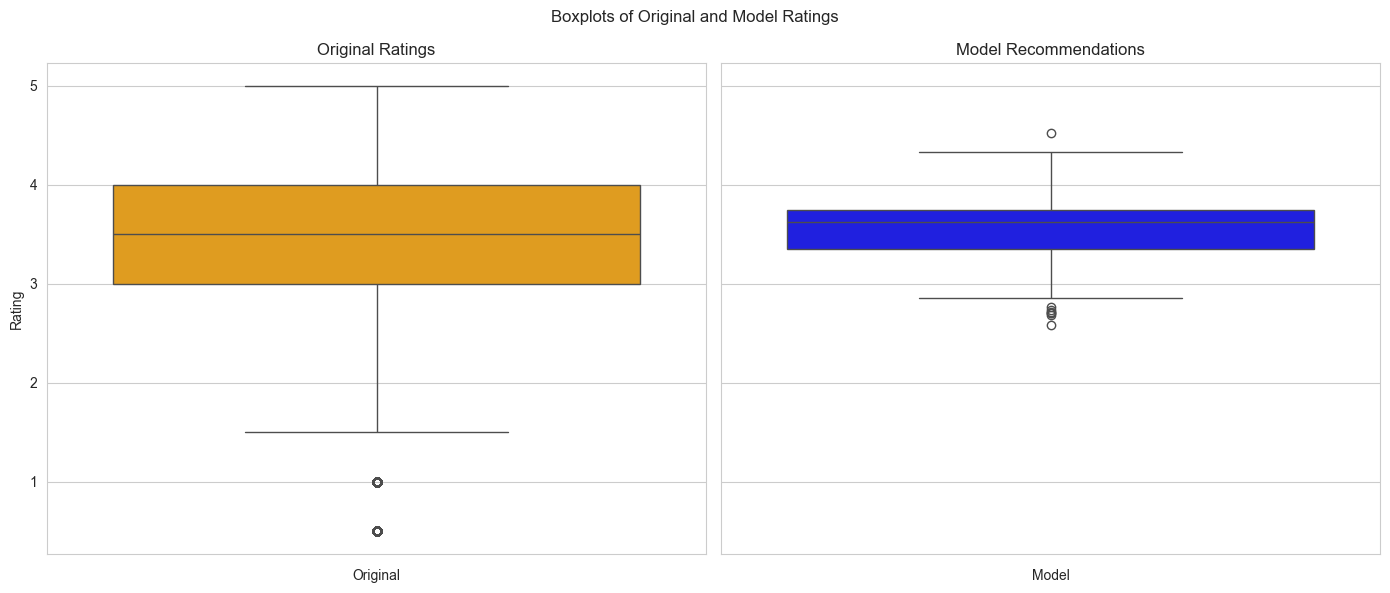

In [496]:
ratings_series = pd.Series(ratings_list)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original Data
sns.boxplot(y=ratings['rating'], ax=axes[0], color='orange')
axes[0].set_title('Original Ratings')
axes[0].set_xlabel('Original')
axes[0].set_ylabel('Rating')

# Model Data
sns.boxplot(y=ratings_series, ax=axes[1], color='blue')
axes[1].set_title('Model Recommendations')
axes[1].set_xlabel('Model')

# Adjust layout
plt.suptitle('Boxplots of Original and Model Ratings')
plt.tight_layout()
plt.show()

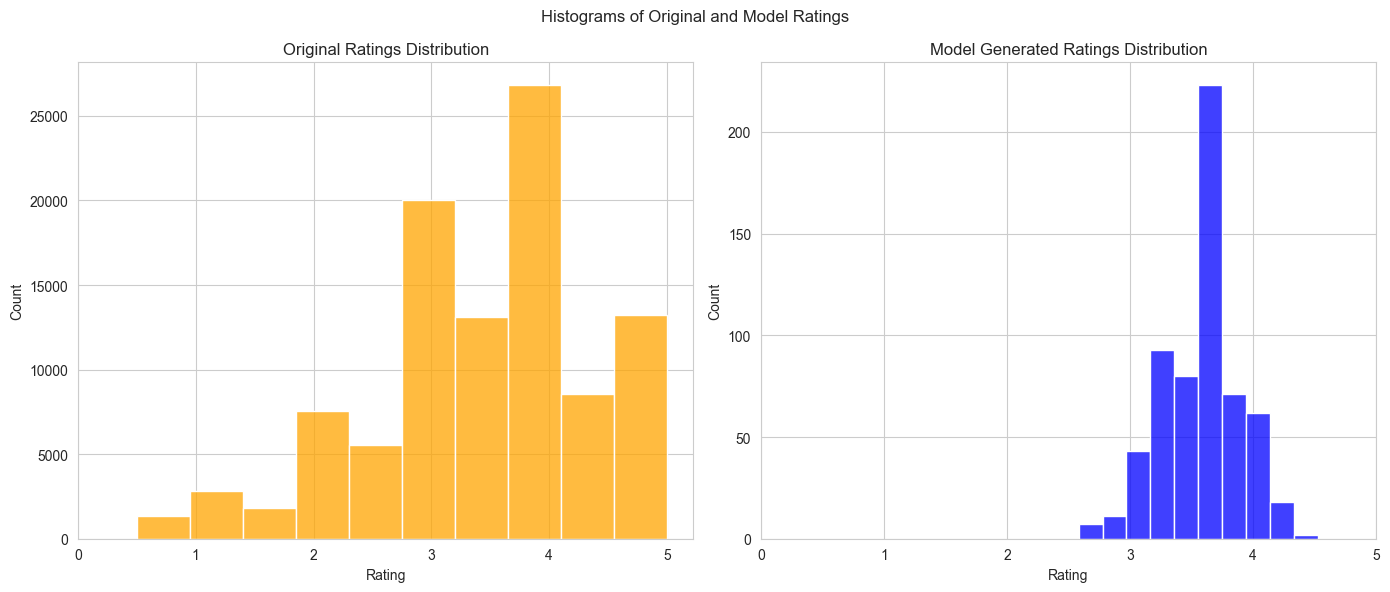

In [497]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
xticks = [0, 1, 2, 3, 4, 5]

bins = 10
# Original Data
sns.histplot(x=ratings['rating'], bins = bins, ax=axes[0], color='orange')
axes[0].set_title('Original Ratings Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].set_xticks(xticks)

# Model Data
sns.histplot(x=ratings_series, bins = bins, ax=axes[1], color='blue')
axes[1].set_title('Model Generated Ratings Distribution')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count')
axes[1].set_xticks(xticks)


# Adjust layout
plt.suptitle('Histograms of Original and Model Ratings')
plt.tight_layout()
plt.show()